#### Description
Identify the level of income qualification needed for the families in Latin America.

#### Problem Statement Scenario
Many social programs have a hard time ensuring that the right people are given enough aid. It's tricky when a program focuses on the poorest segment of the population. This segment of the population can't provide the necessary income and expense records to prove that they qualify. 

In Latin America, a popular method called Proxy Means Test (PMT) uses an algorithm to verify income qualification. With PMT, agencies use a model that considers a family's <u>observable household attributes</u> like the material of their walls and ceiling or the assets found in their homes <u>to classify them and predict their level of need</u>. While this is an improvement, accuracy remains a problem as the region's population grows and poverty declines.

The Inter-American Development Bank (IDB) believes that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT's performance. 

#### Following actions should be performed:
1. Identify the output variable.
2. Understand the type of data.
3. Check if there are any biases in your dataset.
4. Check whether all members of the house have the same poverty level.
5. Check if there is a house without family head.
6. Set poverty level of the members and the head of the house within a family.
7. Count how many null values exist in each of the columns.
8. Remove null value rows of the target variable.
9. Predict the accuracy using random forest classifier.
10. Check the accuracy using random forest with cross validation. 


#### Revisit
* Can revisit the data cleaning and preparation again after model training to check if better scores can be achieved.
* Can relook into suggestions by chatGPT
* Remove features with only 2000+ values as compared to the full 9500 values.

In [ ]:
# Observable household attribute features 
# 1 = unique ID (drop)
# 2 = monthly rent payment
# 3 = overcrowding by bedrooms
# 4 = number of rooms
# 5 = overcrowding by rooms
# 6 = bathroom
# 7 = refrigerator
# 8-9 = tablets owned
# 10-20 = demographics of family
# 21-22 = years of schooling
# 23 - household size
# 24-42 = features describing physical appearance of house
# 43-54 = water, sanitation & electricity provision
# 55-58 = cooking provision
# 59-64 = rubbish disposal
# 65-73 = features describing physical appearance of house
# 74-95 = family member description
# 96-104 = family relationship
# 105-113 = member educational level
# 114-115 = bedroom, overcrowding
# 116-120 = financial state of house (buy, rent etc)
# 121-124 = electronic assets of house
# 125-132 = region family belongs to
# 133 = age
# 134-141 = squared features
# 142 = squared age (drop)

In [1]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import time

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer as Imputer

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Set options for display
warnings.filterwarnings('ignore')

In [89]:
# Load train and test dataset
train = pd.read_csv("./IU 3.6.9 - Python Assignment/dataset/train.csv")
test = pd.read_csv("./IU 3.6.9 - Python Assignment/dataset/test.csv")

#### Question 1 - Identify the output variable
1. Output variable is not present as a column in the test set.

In [90]:
# Question 1 - Identify the output variable
set(train.columns).difference(set(test.columns))

{'Target'}

#### Question 2 - Understand the type of data
1. ID column can be droppped because they don't provide any useful information to the machine learning model. 
2. There are a few columns with missing values.
3. Calculate the percentage of missing values from the column to decide if the feature is to be dropped.
4. Some features are of object type.

In [91]:
# Question 2 - Understand the type of data
# Look at dataset with .info()
train.iloc[:, 0:80].info()
train.iloc[:, 81:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               9557 non-null   object 
 1   v2a1             2697 non-null   float64
 2   hacdor           9557 non-null   int64  
 3   rooms            9557 non-null   int64  
 4   hacapo           9557 non-null   int64  
 5   v14a             9557 non-null   int64  
 6   refrig           9557 non-null   int64  
 7   v18q             9557 non-null   int64  
 8   v18q1            2215 non-null   float64
 9   r4h1             9557 non-null   int64  
 10  r4h2             9557 non-null   int64  
 11  r4h3             9557 non-null   int64  
 12  r4m1             9557 non-null   int64  
 13  r4m2             9557 non-null   int64  
 14  r4m3             9557 non-null   int64  
 15  r4t1             9557 non-null   int64  
 16  r4t2             9557 non-null   int64  
 17  r4t3          

#### Question 3 - Check if there are any biases in your dataset.
1. Columns with high percentage of missing values can be removed as the the relationship between the feature and target cannot be analyzed accurately.
2. However, if the feature is important, removing the observations with missing values might work better.
3. Determine the method to fill in the remaining missing values based on the underlying distribution of the feature.
4. Check if the target counts are balanced between the 4 targets.

In [92]:
# Question 3 - Check if there are any biases in your dataset.
train["Target"].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

#### Question 4 - Check whether all members of the house have the same poverty level.
1. Feature `idhogar` seems to be the household ID.
2. Poverty level is the `"Target"` feature.
3. Group the families together in the dataframe, and create a dictionary with key as the household ID and value as number of different poverty levels within the household.

In [95]:
# Group the household together based on "idhogar" column.
grouped_fam = train.groupby("idhogar", as_index=False)

# Create dictionary with key as household ID and value as number of poverty 
# levels within the household. 
grouped_plvl = {group: len(set(frame["Target"])) for group, frame in grouped_fam}

# If length of set("Target") > 1, it means more than one poverty levels. 
unequal_plvl = dict(filter(lambda item: item[1] > 1, grouped_plvl.items()))

# Covert to data frame. 
unequal_plvl = pd.DataFrame.from_dict(unequal_plvl, orient="index", columns=["plvl"])
unequal_plvl

,plvl
0172ab1d9,2
03f4e5f4d,2
0511912b6,2
078a0b6e2,2
09e25d616,2
...,...
e65d4b943,2
efd3aec61,2
f006348ed,2
f7b421c2c,2


#### Question 5 - Check if there is a house without family head.
1. Check if `parentesco1` is equal to 0 for each of the grouped household based on `idhogar`.
    * This means there isn't a household head within the household. 

In [94]:
# Use the aggregate function to calculate the mean of "parentesco1" in each 
# household.
grouped_fam_count = grouped_fam["parentesco1"].aggregate([np.mean])

# Family without family head would have 0 as their mean 
no_fam_head = grouped_fam_count[grouped_fam_count["mean"] == 0]

no_fam_head

,mean
idhogar,
03c6bdf85,0.0
09b195e7a,0.0
1367ab31d,0.0
1bc617b23,0.0
374ca5a19,0.0
61c10e099,0.0
6b1b2405f,0.0
896fe6d3e,0.0
a0812ef17,0.0


#### Question 6 - Set poverty level of the members and the head of the house within a family.
1. Assuming the question should read as "Set poverty level of the members <u>TO</u> the head of the house within a family".
2. Change the poverty levels of all members within the household to the poverty level of that household head.

In [96]:
# Create a empty dataframe holder
df_holder = pd.DataFrame()

for house_id in unequal_plvl.index:
    
    # Subset out the members from the household
    temp_df = train[train["idhogar"] == house_id]
    
    # Retrieve the poverty level of head of household
    head_plvl = temp_df[temp_df["parentesco1"] == 1]["Target"]
    
    # Set poverty level of members of household to be equal head
    temp_df["Target"] = head_plvl.iloc[0]
    
    # Concatenate the data frames together
    df_holder = pd.concat([df_holder, temp_df], axis=0)

# Drop the members from the train dataframe, then concatenate with new df.
train_dropped = train[~train["idhogar"].isin(unequal_plvl.index)]
train = pd.concat([train_dropped, df_holder])

# Check if shape of data frame is correct.
train.shape


(9557, 143)

#### Question 7 - Count how many null values are existing the columns.
1. Count the number of null values in each column.
2. Calculate the percentage of null values in each column.

In [97]:
# Calulate percentage of missing values from each column
ms_values_count = train.isnull().sum()
ms_values_perc = 100 * train.isnull().sum() / len(train)

ms_values_df = pd.DataFrame({"ms_values_count": ms_values_count,
                             "ms_values_perc": ms_values_perc})
ms_values_df[ms_values_df["ms_values_perc"] > 0]

,ms_values_count,ms_values_perc
v2a1,6860,71.779847
v18q1,7342,76.823271
rez_esc,7928,82.954902
meaneduc,5,0.052318
SQBmeaned,5,0.052318


#### Question 8 - Remove null value rows of the target variable.
1. `Target` column does not contain any null values.

In [98]:
# Check if there is any null values under the target variable
train["Target"].isnull().sum()

0

#### Question 9 - Predict the accuracy using random forest classifier.
1. Convert remaining features of `dtype="object"` into numerical values.
2. Perform additional data preprocessing and cleaning necessary.
3. `meaneduc` feature has missing values. To fill in missing values with mean.

In [101]:
# Convert "dependency", "edjefe" and "edjefa" into numerical features.
total_dependents = train["hogar_nin"] + train["hogar_mayor"]
train["dependency"] = total_dependents / train["hogar_adul"]

# Convert inf values to 0
train["dependency"] = train["dependency"].replace(np.inf, 0)


train["edjefe"] = train["edjefe"].replace({"yes": 1, "no": 0}).apply(int)
train["edjefa"] = train["edjefa"].replace({"yes": 1, "no": 0}).apply(int)


In [102]:
# Check remaining features of type "object"
train.select_dtypes(include=["object"]).columns

Index(['Id', 'idhogar'], dtype='object')

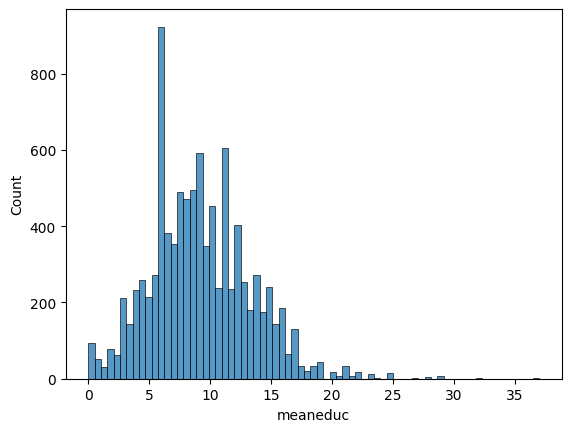

In [103]:
# Plot histogram of feature to determine its distribution
sns.histplot(train["meaneduc"]);

As mentioned previously, I'm going to try two different cross validation with random forest, one (Part I) to drop the columns containing high percentage of missing values, another (Part II) to remove the events (family members in household in this case) that carry missing values for `v2a1` feature, which is the monthly rent payment of house that they live in. 

In [104]:
# Random Forest Part I - Dropping Columns
# Drop columns with missing values and not useful
train_I = train.drop(["Id", "v2a1", "v18q1", "idhogar", "rez_esc"], axis=1)
train_I["dependency"] = train_I["dependency"].astype(np.float32)


# Perform train test split before missing in missing values
features = train_I.drop("Target", axis=1)
target = train_I["Target"]

x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=1988)


imputer = Imputer(strategy="mean")
imputer.fit(x_train);

x_train = imputer.transform(x_train)
x_test = imputer.transform(x_test)

x_train = pd.DataFrame(x_train, columns=features.columns)
x_test = pd.DataFrame(x_test, columns=features.columns)


In [105]:
# Question 9 - Predict the accuracy using random forest classifier.
rf = RandomForestClassifier(random_state=1988)
rf.fit(x_train, y_train);
y_pred = rf.predict(x_test)

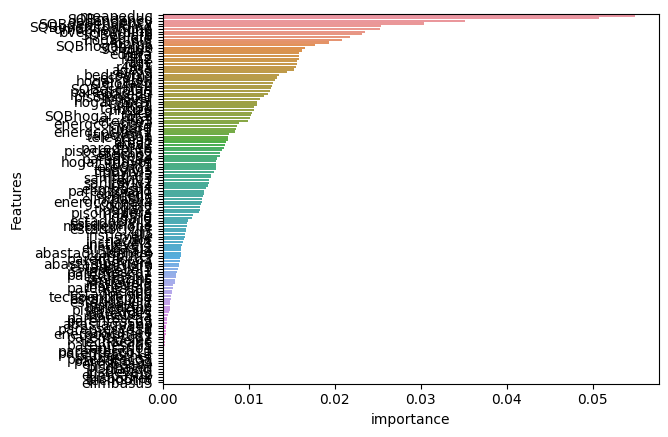

In [108]:
feat_imp = pd.DataFrame()
feat_imp['Features'] = x_train.columns.values
feat_imp['importance'] = rf.feature_importances_
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
sns.barplot(y="Features", x="importance", data=feat_imp);

There are multiple features that have importance of < 0.001 (arbitrary value). I will remove these features from the second cross validated random forest to speed things up and to see if the predictions will remain accurate. They might be associated with other features in the dataset, that's why the model did not use them. Or if they really do not impact the target outcome of this dataset, basically the features are not associated with the poverty level of the household. 

In [115]:
low_impt = feat_imp[feat_imp["importance"] < 0.001]["Features"].values

array(['techoentrepiso', 'estadocivil4', 'estadocivil1', 'instlevel6',
       'paredzinc', 'pisonotiene', 'pareddes', 'instlevel7',
       'parentesco4', 'parentesco9', 'abastaguano', 'v14a',
       'parentesco11', 'sanitario6', 'energcocinar1', 'parentesco7',
       'noelec', 'techocane', 'parentesco5', 'sanitario1', 'parentesco10',
       'parentesco12', 'paredother', 'parentesco8', 'paredfibras',
       'elimbasu4', 'pisonatur', 'planpri', 'instlevel9', 'elimbasu6',
       'pisoother', 'techootro', 'elimbasu5'], dtype=object)

In [122]:
# Create confusion matrix to check the accuracy and other metrics for 
# multi-categories classification
c_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(c_matrix, "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 110    5    0   19]
 [   0  238    0   35]
 [   2    2  206   47]
 [   0    7    2 1239]] 

Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.82      0.89       134
           2       0.94      0.87      0.91       273
           3       0.99      0.80      0.89       257
           4       0.92      0.99      0.96      1248

    accuracy                           0.94      1912
   macro avg       0.96      0.87      0.91      1912
weighted avg       0.94      0.94      0.94      1912



#### Question 10 - Check the accuracy using random forest with cross validation. 
1. Tuning of hyperparameters.
2. `max_depth` was initially set at `2-10`, which returns `max_depth=10` as best parameter.
3. `max_depth` was set set at `11-20`, which returns `max_depth=20` as best parameter.
4. `max_depth` was set set at `21-30`, which returns `max_depth=21` as best parameter.
5. It took ~25 minutes to run the entire cross validation for this round. 

In [118]:
rf_cv = RandomForestClassifier(random_state=1998)
np.random.seed(2008)
start = time.time()

param_dist = {"max_depth": list(range(21, 30)),
              "max_features": ["sqrt", "log2", None],
              "criterion": ["gini", "entropy"]}

cv_tree = GridSearchCV(rf_cv, 
                       cv=10, 
                       param_grid=param_dist,
                       n_jobs=-1,
                       scoring="accuracy")

cv_tree.fit(x_train, y_train)
print("Best parameters using grid search: \n",
      cv_tree.best_params_)
end = time.time()
print("Time taken in grid search: {0:.2f}".format(end-start))

Best parameters using grid search: 
 {'criterion': 'entropy', 'max_depth': 21, 'max_features': None}
Time taken in grid search: 499.98


In [121]:
# Train new model based on optimized parameters
rf_cv = RandomForestClassifier(random_state=1998)

rf_cv.set_params(criterion="entropy", max_features=None,max_depth=21)
rf_cv.fit(x_train, y_train)
y_pred_cv = rf_cv.predict(x_test)

# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred_cv)

print("Confusion Matrix:")
print(c_matrix, "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_cv))

Confusion Matrix:
[[ 122    2    0   10]
 [   0  256    0   17]
 [   3    3  231   20]
 [   0    9    1 1238]] 

Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.91      0.94       134
           2       0.95      0.94      0.94       273
           3       1.00      0.90      0.94       257
           4       0.96      0.99      0.98      1248

    accuracy                           0.97      1912
   macro avg       0.97      0.93      0.95      1912
weighted avg       0.97      0.97      0.97      1912



A slight improvement of the accuracy score, and other metrics when the parameters are optmized. Next is to run the cross validation a second time, with rows carrying missing values for the feature `v2a1`, and drop the features previously shown not to be important to the model. 

In [140]:
# Random Forest Part II - Dropping events
# Drop columns with missing values and not useful

features_to_drop = ["Id", "v18q1", "idhogar", "rez_esc"] + list(low_impt)
train_II = train.drop(features_to_drop, axis=1).dropna()
train_II.shape

(2693, 106)

In [146]:
# Check if the "Target" outcome still have a good distribution and number
train_II["Target"].value_counts()

4    1906
2     321
3     299
1     167
Name: Target, dtype: int64

In [141]:
# Perform train test split before missing in missing values
features = train_II.drop("Target", axis=1)
target = train_II["Target"]

x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=1988)

imputer = Imputer(strategy="mean")
imputer.fit(x_train);

x_train = imputer.transform(x_train)
x_test = imputer.transform(x_test)

x_train = pd.DataFrame(x_train, columns=features.columns)
x_test = pd.DataFrame(x_test, columns=features.columns)

In [144]:
# Training the model
rf = RandomForestClassifier(random_state=1988)
rf.fit(x_train, y_train);
y_pred_II = rf.predict(x_test)

# Create confusion matrix
c_matrix = confusion_matrix(y_test, y_pred_II)

print("Confusion Matrix:")
print(c_matrix, "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_II))

Confusion Matrix:
[[ 31   0   0   0]
 [  0  67   0   5]
 [  0   0  55   6]
 [  0   0   0 375]] 

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        31
           2       1.00      0.93      0.96        72
           3       1.00      0.90      0.95        61
           4       0.97      1.00      0.99       375

    accuracy                           0.98       539
   macro avg       0.99      0.96      0.97       539
weighted avg       0.98      0.98      0.98       539



In [148]:
# Repeat the cross validation with the new training set
rf_cv = RandomForestClassifier(random_state=1998)

param_dist = {"max_depth": range(2, 30),
              "max_features": ["sqrt", "log2", None],
              "criterion": ["gini", "entropy"]}

cv_tree = GridSearchCV(rf_cv, 
                       cv=10, 
                       param_grid=param_dist,
                       n_jobs=-1,
                       scoring="accuracy")

cv_tree.fit(x_train, y_train)
print("Best parameters using grid search: \n",
      cv_tree.best_params_)

Best parameters using grid search: 
 {'criterion': 'entropy', 'max_depth': 15, 'max_features': None}


In [149]:
# Train new model based on optimized parameters
rf_cv = RandomForestClassifier(random_state=1998)

rf_cv.set_params(criterion="entropy", max_features=None,max_depth=15)
rf_cv.fit(x_train, y_train)
y_pred_cv_II = rf_cv.predict(x_test)

# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred_cv_II)

print("Confusion Matrix:")
print(c_matrix, "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_cv_II))

Confusion Matrix:
[[ 31   0   0   0]
 [  0  70   0   2]
 [  0   0  56   5]
 [  0   1   2 372]] 

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        31
           2       0.99      0.97      0.98        72
           3       0.97      0.92      0.94        61
           4       0.98      0.99      0.99       375

    accuracy                           0.98       539
   macro avg       0.98      0.97      0.98       539
weighted avg       0.98      0.98      0.98       539



Without the cross validation run, there seems to be a slight improvement over the first iteration of the random forest, where features carrying high percentage of missing values were dropped. This might mean that the monthly rent payment feature is important in determining if the household belong to a certain poverty level. 

With cross validation on the small dataset, there is not much improvement in the metrics over the original random forest. 

The importance of the `v2a1` feature can be seen in the following table, where it ranks second on the importance. 

In [152]:
feat_imp = pd.DataFrame()
feat_imp['Features'] = x_train.columns.values
feat_imp['importance'] = rf_cv.feature_importances_
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

feat_imp.head()

,Features,importance
66,dependency,0.112696
0,v2a1,0.101741
103,SQBmeaned,0.071116
69,meaneduc,0.064803
102,SQBdependency,0.029707
